In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import torch.optim as optim
import torch.nn as nn

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


In [3]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [4]:
# -----------------------------
# Custom Dataset for River Segmentation
# -----------------------------
class RiverSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        """
        Args:
            images_dir (str): Path to directory with images.
            masks_dir (str): Path to directory with mask .npy files.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        # List image files (adjust extensions as needed)
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_filename)
        # Assumes mask file has the same basename with .npy extension
        mask_filename = os.path.splitext(img_filename)[0] + '.pn.npy'
        mask_path = os.path.join(self.masks_dir, mask_filename)

        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        mask = np.load(mask_path)  # Assume mask is a 2D numpy array of labels
        # Convert mask to tensor (long type for CrossEntropyLoss)
        mask = torch.from_numpy(mask).long()
        return image, mask

In [5]:
# -----------------------------
# Define Transforms, Dataset, and DataLoader
# -----------------------------
transform = T.Compose([
    T.ToTensor() #,
    # Normalize with ImageNet statistics or adjust if needed
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [16]:
# Replace these with your actual paths
images_dir = 'initial_images'
masks_dir = 'initial_masks'

dataset = RiverSegmentationDataset(images_dir, masks_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

In [17]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [18]:
# -----------------------------
# Optimizer and Loss
# -----------------------------
optimizer = optim.Adam(sam2_model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()  # Expects logits [B, C, H, W] and target [B, H, W]

In [19]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    sam2_model.train()
    for i, (images, masks) in enumerate(dataloader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        masks_pred = predictor.set_image(images)
        loss = loss_fn(masks_pred, masks)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f"Epoch {epoch}, Iteration {i}, Loss: {loss.item()}")

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "<string>", line 1, in <module>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
  File "/opt/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
    exitcode = _main(fd, parent_sentinel)
                             ^ ^^^^^^^^^^^^^^^^^    ^exitcode = _main(fd, parent_sentinel)^^^^^^^
^^^^^^^^^^^^^^^^^^^^^
^^^^^  File "/opt/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 132, in _main

  File "/opt/anaconda3/lib/python3.11/multiprocessing/

RuntimeError: DataLoader worker (pid(s) 8115) exited unexpectedly

In [ ]:
torch.save(sam2_model.state_dict(), f"sam2_model_finetuned_epoch_{epoch + 1}.pt")

In [8]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

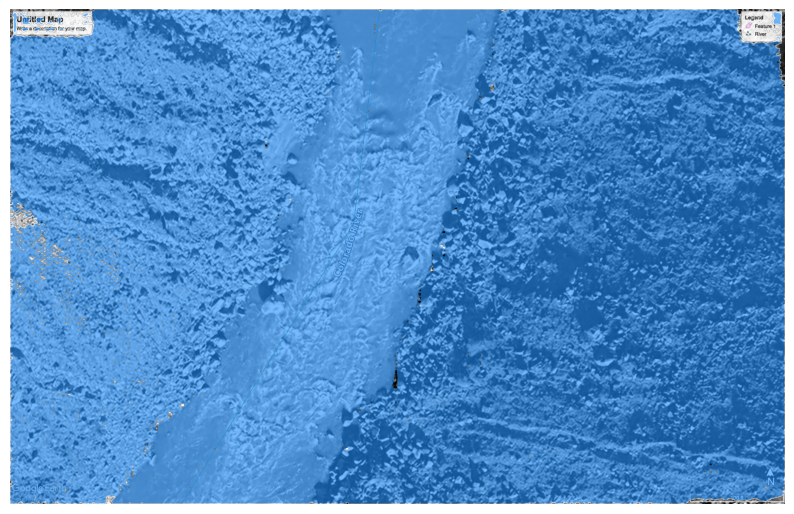

In [9]:
input_point = np.empty((0, 2))    # Correct shape for zero points
input_label = np.empty((0,), dtype=int)  # Correct shape for zero labels

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)